In [11]:
# Read stocks
import yfinance as yf

import pandas as pd
import numpy as np

import base64

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [12]:
COLUMN_MAPPING = {
    'symbol': 'Symbol', 'name': 'Name', 'industry': 'Industry', 'units': 'Units',
    'current_price': 'Curr Price', 'paid': 'Paid Price', 'market_value': 'Mkt Value', 'cost': 'Cost', 'day_change': 'Day Change $',
    'day_change_pct': 'Day Change %', 'gain_loss': 'Gain/Loss $', 'gain_loss_pct': 'Gain/Loss %',
    'last_12_months': 'Price Change - Last 12 Months',
    # Need these 2 for summary df
    'tot_cost': 'Total Cost', 'tot_market_value' : 'Total Market Value'
}
# Using plotly dark template
TEMPLATE = 'plotly_dark'

## Load the transaction history

In [13]:
hist_df = pd.read_excel('data/transactions.xlsx', sheet_name='History')
hist_df

,Date,Symbol,Units,Paid,Price,Currency
0,30-12-2019,HAL,200.00,4952.0000,24.760000,USD
1,23-03-2020,HAL,-180.00,-1152.0000,6.400000,USD
2,24-10-2021,TEAM,50.00,22900.0000,458.000000,USD
3,28-11-2022,GOOG,100.00,9625.0000,96.250000,USD
4,29-11-2022,AMZN,20.00,1848.4000,92.420000,USD
5,08-12-2022,GOOG,20.00,1871.2000,93.560000,USD
6,11-12-2022,TEAM,-30.00,-4410.0000,147.000000,USD
7,20-12-2022,GOOG,20.00,1792.6000,89.630000,USD
8,23-12-2022,AMZN,30.00,2557.5000,85.250000,USD
9,08-01-2023,GTLB,50.00,1510.5000,30.210000,USD


## Sparklines

In [14]:
def sparkline(df, Avg):
    fig = go.Figure()

    # Plot the Close price
    fig.add_trace(go.Scatter(x=df.index, y=df['Close'], line_color='lightgreen', line_width=1))

    # Plot the Avg line
    fig.add_hline(y=Avg, line_color='indianred', line_width=1)

    # hide and lock down axes
    fig.update_xaxes(visible=False, fixedrange=True)
    fig.update_yaxes(visible=False, fixedrange=True)
    
    # strip down the rest of the plot
    fig.update_layout(
        template=TEMPLATE,
        width=250,
        height=40,        
        showlegend=False,
        margin=dict(t=1,l=1,b=1,r=1)
    )
    
    # disable the modebar for such a small plot - fig.show commented out for debugging purposes
    # fig.show(config=dict(displayModeBar=False))

    png = plotly.io.to_image(fig)
    png_base64 = base64.b64encode(png).decode('ascii')
    
    return '<img src="data:image/png;base64,{}"/>'.format(png_base64)

## Collect Data

In [15]:
# Dictionary to collect data to create a DF later
data = {
    'symbol': [],
    'industry': [],
    'units': [],
    'paid': [],
    'current_price': [],
    'cost': [],
    'market_value': [],
    'day_change': [],
    'day_change_pct': [],
    'gain_loss': [],
    'gain_loss_pct': [],
    'last_12_months': []
}
# Total units, group by Symbol
symbols = hist_df.groupby('Symbol')['Units'].sum()
# Drop any symbols when units are zero (we have sold them)
symbol_list= symbols.where(symbols > 0).dropna().index.to_list()

for symbol in symbol_list:
    units = hist_df.query("Symbol == @symbol")['Units'].sum()

    ticker = yf.Ticker(symbol)
    
    data['symbol'].append(ticker.info['symbol'])
    data['industry'].append(ticker.info['industry'])
    data['units'].append(units)
    current_price = ticker.info['currentPrice']
    data['current_price'].append(current_price)
    # Round to 2 decimal points
    market_value = round(units * current_price, 2)
    data['market_value'].append(market_value)

    # Prev close value to calculate day change
    prev_close = ticker.info['previousClose']
    day_change = (current_price - prev_close) * units
    data['day_change'].append(day_change)
    data['day_change_pct'].append(((current_price/prev_close) - 1) * 100)

    # History data for 12 months
    history = ticker.history(period='1y')['Close']

    # Convert the history series to a DF
    history_df = history.to_frame()
    # Average price we bought the stock (exclude sell transactions)
    t_df = hist_df.query("Symbol == @symbol & Units >= 0")[['Price', 'Units']]
    # Weighted average
    avg = round(np.average(a=t_df.Price, weights=t_df.Units))
    # Average weighted proice we have paid
    data['paid'].append(avg)
    cost = units * avg
    data['cost'].append(cost)
    
    data['gain_loss'].append(market_value - cost)
    data['gain_loss_pct'].append(((market_value/cost) - 1) * 100)

    # Add the sparkline for 12 month history data
    data['last_12_months'].append(sparkline(history_df, avg))

## DF Styler related utilities

In [16]:
def make_pretty(styler):
    # Column formatting
    styler.format({
        'units': '{:.2f}', 'Price': '${:.2f}', 'paid': '${:.2f}', 'cost': '${:,.2f}',
        'current_price': '${:.2f}', 'market_value': '${:,.2f}'})

    # Grid - uncomment this line if you want grids
    # styler.set_properties(**{'border': '0.1px solid darkgrey'})

    # No index
    styler.hide(axis='index')

    # Left text alignment for some columns
    styler.set_properties(subset=['symbol', 'industry'], **{'text-align': 'left'})

    styler.format(dollar_change, subset=['day_change','gain_loss'])
    styler.format(pct_change, subset=['day_change_pct', 'gain_loss_pct'])
    styler.map(color_arrow, subset=['day_change','day_change_pct','gain_loss', 'gain_loss_pct'])
    return styler

def dollar_change(val):
    if val > 0:
        return f"{'🡅'} ${abs(val):,.2f}"
    elif val < 0:
        return f"{'🡇'} $({abs(val):,.2f})"
    else:
        return f"${val:,.2f}"
    
def pct_change(val):
    if val > 0:
        return f"{'🡅'} {abs(val):.2f}%"
    elif val < 0:
        return f"{'🡇'} ({abs(val):.2f})%"
    else:
        return f"{val:.2f}%"
    # return f"{'↑' if val > 0 else '↓'} {abs(val):.2f}" if val != 0 else f"{val:.2f}"

def color_arrow(val):
    return "color: green" if val > 0 else "color: indianred" if val < 0 else ""

def column_formatter(name):
    return COLUMN_MAPPING[name]

## Create Portfolio DataFrame

Symbol,Industry,Units,Paid Price,Curr Price,Cost,Mkt Value,Day Change $,Day Change %,Gain/Loss $,Gain/Loss %,Price Change - Last 12 Months
AMZN,Internet Retail,50.00,$88.00,$146.30,"$4,400.00","$7,315.00",🡅 $10.50,🡅 0.14%,"🡅 $2,915.00",🡅 66.25%,
DDOG,Software - Application,20.23,$95.00,$116.50,"$1,921.85","$2,356.80",🡇 $(1.42),🡇 (0.06)%,🡅 $434.95,🡅 22.63%,
GOOG,Internet Content & Information,130.00,$95.00,$132.48,"$12,350.00","$17,222.40",🡇 $(187.20),🡇 (1.08)%,"🡅 $4,872.40",🡅 39.45%,
HAL,Oil & Gas Equipment & Services,70.45,$27.00,$37.33,"$1,902.15","$2,629.90",🡅 $21.13,🡅 0.81%,🡅 $727.75,🡅 38.26%,
TEAM,Software - Application,20.00,$458.00,$191.27,"$9,160.00","$3,825.40",🡅 $6.40,🡅 0.17%,"🡇 $(5,334.60)",🡇 (58.24)%,

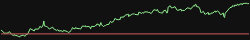
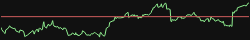
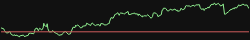
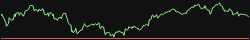
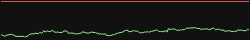

In [17]:
df = pd.DataFrame(data)

df.style.pipe(make_pretty).set_caption('My Stock Dashboard').set_table_styles(
    [{'selector': 'th.col_heading', 'props': 'text-align: center'},
     {'selector': 'caption', 'props': [('text-align', 'center'),
                                       ('font-size', '12pt'), ('font-weight', 'bold')]}]).format_index(column_formatter, axis=1) 

## Portfolio Breakdown

In [18]:
labels = df['symbol']
values = df['market_value']

# Construct a 2 x 2 Plotly figure
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'pie'}, {'type': 'pie'}]],
                    subplot_titles=('Stock', 'Industry'),
                    horizontal_spacing= 0.15)

# Use `hole` to create a donut-like pie chart
fig.add_trace(go.Pie(labels=labels, values=values, hole=.5, name='Market Value',
                     marker = dict(line = dict(color = 'black', width = 2)),  legendgroup = '1'), row=1, col=1)
fig.add_trace(go.Pie(labels=df['industry'], values=values, hole=.5, name='Industry Value',
                     marker = dict(line = dict(color = 'black', width = 2)),  legendgroup = '2'), row=1, col=2)
fig.update_layout(
    title='Portfolio Breakdown',
    template=TEMPLATE,
    width=1000,
    height=400,
)

fig.show()

## Portfolio Growth

In [19]:
fig = px.bar(df, x='symbol', y='gain_loss_pct')
fig['layout']['yaxis']['title']='Growth %'
fig['layout']['xaxis']['title']='Symbol'
fig.update_layout(
    title='Portfolio Growth',
    template=TEMPLATE,
    width=600,
    height=400,
)

fig.show()

## Portfolio summary

In [20]:
cost = df['cost'].sum()
market_value = df['market_value'].sum()
summary_df = pd.DataFrame(np.array([[cost, market_value, 0, 0]]),
                   columns=['tot_cost', 'tot_market_value', 'gain_loss', 'gain_loss_pct'])
gain = market_value - cost
summary_df.at[0, 'gain_loss'] = gain
summary_df.at[0, 'gain_loss_pct'] = (gain/cost) * 100

summary_df.style.set_caption('My Portfolio Summary').set_table_styles(
    [{'selector': 'th.col_heading', 'props': 'text-align: center'},
     {'selector': 'caption', 'props': [('text-align', 'center'),
                                       ('font-size', '12pt'), ('font-weight', 'bold')]}]).map(
    color_arrow, subset=['gain_loss','gain_loss_pct']).format({
        'tot_cost': '${:,.2f}', 'tot_market_value': '${:,.2f}'}).format(
    dollar_change, subset=['gain_loss']).format(pct_change, subset=['gain_loss_pct']).format_index(
    column_formatter, axis=1).hide(axis='index')

Total Cost,Total Market Value,Gain/Loss $,Gain/Loss %
"$29,734.00","$33,349.50","🡅 $3,615.50",🡅 12.16%
